## Setup and Data Import

In [1]:
import numpy as np

import pandas as pd
pd.options.display.max_rows = None
pd.options.display.max_columns = None

import sys
sys.path.insert(0,'..')

import Imputation_Module as imp # imports csv files
import FeatureEngineering_Module as fe
import Encoding_Module as ec

from sklearn.metrics import mean_squared_error, mean_squared_log_error
import sklearn.linear_model as lm
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor

import joblib

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

## Imputation and Feature Engineering

In [2]:
train, test = imp.impute_data()

train = fe.FeatureEngineering(train)
test = fe.FeatureEngineering(test)

train_dummies, test_dummies = fe.Dummify(train, test)

train_ec, test_ec = ec.encode(train, test)

In [3]:
X = train_dummies.drop('SalePrice', 1)
y = train_dummies.SalePrice

In [4]:
X_ec = train_ec.drop('SalePrice', 1)
y_ec = train_dummies.SalePrice

## Modeling

### Linear Modeling with Log(y)

In [5]:
X_train, X_test, y_train, y_test \
    = ms.train_test_split(X, np.log(y), test_size=0.2, random_state=0)

In [6]:
def linear_model(model, X=X_train, y=y_train):
    model.fit(X, y)
    score = model.score(X, y)
    y_pred = model.predict(X_test)

    RMSLE = mean_squared_error(y_test, y_pred, squared=False)
    print('%s R^2: %0.5f'
          % (type(model).__name__, score.mean()))
    print('Root Mean Squared Log Error: %0.5f' % RMSLE)

#### Baseline

In [7]:
ols = lm.LinearRegression()
linear_model(ols)

LinearRegression R^2: 0.93146
Root Mean Squared Log Error: 0.11501


#### Ridge

In [8]:
ridgecv = lm.RidgeCV(alphas=np.logspace(-5, 5, 100), normalize=True)
linear_model(ridgecv)

RidgeCV R^2: 0.92983
Root Mean Squared Log Error: 0.11273


#### Lasso

In [9]:
lasso = lm.LassoCV(alphas=np.logspace(-7, -1, 100), max_iter=10000, normalize=True, cv=10)
linear_model(lasso)

LassoCV R^2: 0.92857
Root Mean Squared Log Error: 0.11116


#### Elastic Net

In [10]:
net = lm.ElasticNetCV(alphas=np.logspace(-7, -1, 100), max_iter=10000, normalize=True, cv=10)
linear_model(net)

ElasticNetCV R^2: 0.92791
Root Mean Squared Log Error: 0.11247


### Tree Modeling

In [11]:
Xec_train, Xec_test, yec_train, yec_test = ms.train_test_split(X_ec, y_ec, test_size=0.2, random_state=0)

In [12]:
def get_error(model, X_train=Xec_train, y_train=yec_train, X_test=Xec_test, y_test=yec_test):
    model.fit(X_train, y_train)
    train_error = 1 - model.score(X_train, y_train)
    test_error  = 1 - model.score(X_test, y_test)
    print("The training error is: %.5f" %train_error)
    print("The test error is: %.5f" %test_error)
    
    y_pred = model.predict(X_test)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print('Root Mean Squared Log Error: %0.5f' % RMSLE)

#### Baseline

In [13]:
tree_model = tree.DecisionTreeRegressor(random_state=0)
get_error(tree_model)

The training error is: 0.00000
The test error is: 0.23744
Root Mean Squared Log Error: 0.18801


In [14]:
# grid_para_tree = {'criterion': ["mse", "friedman_mse", "mae"],
#                   'max_depth': range(1, 12)}
# grid_search_tree = ms.GridSearchCV(tree_model, grid_para_tree, cv=10)

# get_error(grid_search_tree)
# print('The best score is %.4f' %grid_search_tree.best_score_)
# print('The best parameters are %s' %grid_search_tree.best_params_)
# # -------------------------------------------------------------
# # RESULTS:

# # The training error is: 0.20091
# # The test error is: 0.26604
# # The best score is 0.7259
# # The best parameters are {'criterion': 'mse', 'max_depth': 4}

#### Gradient Boosting

##### Baseline

In [15]:
gb_model = GradientBoostingRegressor(random_state=0)
get_error(gb_model)

The training error is: 0.04000
The test error is: 0.08469
Root Mean Squared Log Error: 0.11283


In [16]:
# gb_model = GradientBoostingRegressor(random_state=0)

# grid_para_gb = {'loss': ['ls', 'lad', 'huber', 'quantile'],
#                 'n_estimators': [50, 200, 400],
#                 'subsample': [1.0, 0.8],
#                 'criterion': ["mse", "friedman_mse", "mae"],
#                 'max_depth': range(1, 10)}
# grid_search_gb = ms.GridSearchCV(gb_model, grid_para_gb, cv=10, n_jobs=-1)

# get_error(grid_search_gb)
# print('The best score is %.4f' %grid_search_gb.best_score_)
# print('The best parameters are %s' %grid_search_gb.best_params_)
# joblib.dump(grid_search_gb.best_estimator_, 'gb_model_ames_housing.pkl')
# # -------------------------------------------------------------
# # TAKES SEVERAL HOURS TO RUN. SAVED AS 'gb_model.pkl'
# # RESULTS:

# # The training error is: 0.03764
# # The test error is: 0.08361
# # The best score is 0.8975
# # The best parameters are {'criterion': 'mse', 'loss': 'huber', 'max_depth': 2,
# #                          'n_estimators': 400, 'subsample': 0.8}

In [17]:
gb_final = joblib.load('gb_model.pkl')
get_error(gb_final)

The training error is: 0.03764
The test error is: 0.08361
Root Mean Squared Log Error: 0.11674


The baseline Gradient Boosting model generated decent results - no severe over or under-fitting with an error rate less than 10%. A grid search was run on 5 parameters regardless and resulted in slightly reduced errors in both the training and test sets. It is what is used for the following analysis, but was generally not worth the computational expensive of the grid search.

##### Feature Importances

In [18]:
feat_imp = pd.DataFrame({'feature': np.array(Xec_train.columns),
                         'importance': gb_final.feature_importances_})

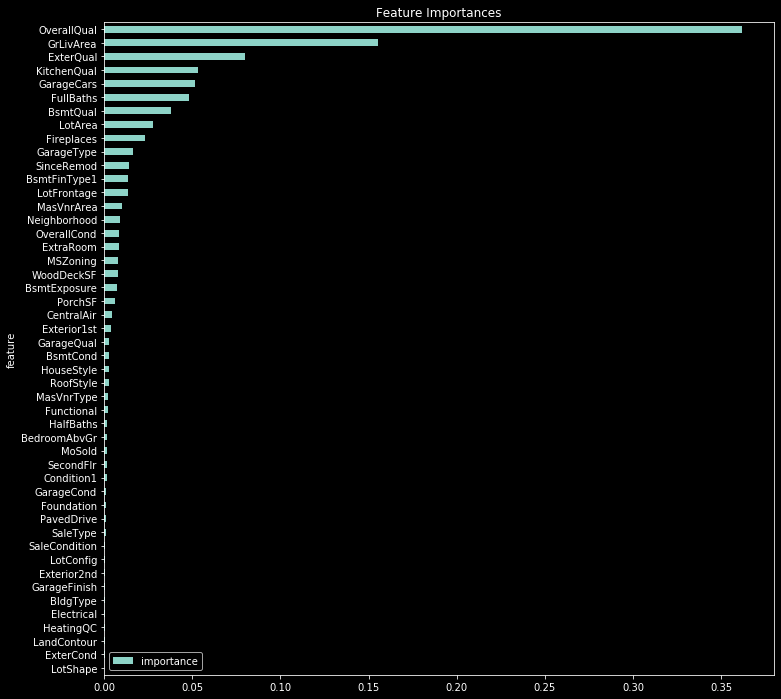

In [19]:
feat_imp.sort_values('importance').plot.barh(y='importance', x='feature', figsize=(12,12),
                   title='Feature Importances');

The top 6 features that contribute the most to SalePrice are OverallQual, GrLivArea, GarageCars, ExteriorQual, FullBaths, BsmtQual, with a roughly expontial increase in importance.

This indicates that the single most important factor when historically selling a home in Ames, Iowa, is "the overall material and finish of the house." A home with any set of features (large/small, good/bad neighborhood, etc.) will sell better than any other house with comparable features as long as the home has high-quality materials and finishes. Therefore, when planning to sell a home, remodel a home with a future sale in mind, or puchase a home for investment, it would be wise to consider the overall quality first and foremost.

Exterior quality is the 4th most influential feature on SalePrice and Basement Quality is the 6th, understandably following up Overall Quality. This indicates that if one is prioritizing areas to remodel, indoor finishes, followed by outdoor finishes and finally basement finishes may be the best approach. That said, if remodeling over several years with plans to sell the home in the future, it may be wise to reverse this order given that Years Since Remodel is the 11th of 48 most important feature, so that the most outdated finishes will be those in the basement and the most recent finishes will be those in primary living areas.

While Above-Ground SF (GrLivArea) is the second most influential on Sale Price, one must consider the costs associated with increasing this feature. It may be far more worthwhile to simply replace fixtures and/or add cladding to increase the value of a home than expand or add rooms or floors. Also to be considered is lot size and local regulations - some homes may be significantly limited in their ability to grow.

The Garage Size (by car capacity) can be thought of similarly to Above-Ground SF - while important for sale price, the costs and feasibility of adding garage space may not be worth it. Also to note is that simply increasing square footage of a garage is not as important as being able to fit an entire additional vehicle in a garage, so adding/building a workspace or storage area will likely not be significantly reflected in a higher Sale Price. Where garage size may be most valuable is at homes that have neither a garage nor carport. Adding some sort of vehicle storage structure, even poor quality, may be worthwhile, even though it has a high cost.

Of the 6 most important features, the number of Full Baths comes in 5th. When considering increasing SF or what specific rooms to remodel, bathrooms are a sound bet. Adding a bathroom is less square footage but requires more plumbing and finishes than adding a bedroom or bonus room, so the ratio of bedrooms to bathrooms would be smart to consider. If a home already has one bathroom per bedroom, adding a bathroom may not add as much value as adding a bathroom to a 3 bedroom/1 bath home.